## Models and Analysis

The following model architectures are trained/used in this excericise:
    1. SSD mobilenet v1
    2. Faster R-CNN with Inception Resnet v2, Atrous version
    3. SSD inception v2
Model 1 trained from the scratch while pre-trained models are used to generate and analyse the results from Model 2 and 3. I wanted to try and compare YOLO_v2 (using darknet) also but due to time constraint I was not able to use it.
Since we need to detect red round signs, the model is trained for 3 classes, **red rounds, non-red rounds and triangular** .
* **Model Architectures**

It is very hard to compare various model architectures but for real life applications like Traffic Sign Detection we use make choices by comparing performance and accuracy of detector types. The mean average precision (mAP) is used in measuring accuracy. For pre-trained models, these values are taken from the original references.The below table summarizs the comparison of following measures: number of parameters, step time (cpu) and mAP.

| Model Name                                            | No. of Parameters           |  mAP   |
| ------------------------------------------------------|-----------------------------| -------|
| SSD mobilenet v1                                      | 5572809                     |  61.64 |
| Faster R-CNN with Inception Resnet v2, Atrous version | 59412281                    |  95.77 |
| SSD inception v2                                      | 13474849                    |  66.10 |

---
* **Hyperparameters tuning**

ssd_mobilenet_v1 was trained with the following hyperparameters,
    1. Batch Size: 24
    2. Learning rate: 0.004
    3. Learning rate decay: 0.95
    4. Momentum: 0.9
    5. Total Steps: 5000/40000/100000/2000000 
    Best accuracy was achieved on 200000 but due to limited compute power, I was not able to explore more.

---
* **Training Strategy**

Tensorflow object detection code is used for training the model. The tf record of the the input is created (as opposed to the data processing done in Part-1). Object detection module provides the extensive code to train the model. The setup of the code is explained [here](https://github.com/rishabhbhardwaj/SignDetection/blob/master/README.md)
The training is done on CPU (2.3 GHz Intel Core i5, 16GB RAM).

---
* **Changes from Part1**

    1. Change of framework from PyTorch to Tensorflow
        Tensorflow object detection is very rich and I found various pre-trained model based on this.
        Second reason is I want to demonstarate my understaing of various Deep Learning frameworks, for data anaylysis I used pytorch and for training I used tensorflow for model training and detection from pre-trained models.
    2. Data Changes 
       TFRecords are created for the training data.The following transforms are applied while training: random horizontal flip and ssd random crop. 
    
---


In [1]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from tf_utils import *

## Training

ssd_mobilenet_v1 is trained with the tensorflow object detection API.

Run the below command to train the model,

```
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
python object_detection/legacy/train.py --logtostderr --pipeline_config_path ssd_mobilenet_v1.config --train_dir gtsdb_data/model/ssd_mobilenet_v1```

The `ssd_mobilenet_v1.config` has the all the hyperparaters configured, along with other architecture variables.

## Using Pre-Trained Models

### Loading trained (or pre-trained) model and detecting bounding boxes
Change the model path in utils to get results with different model.

In [2]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Detection using trained (or pre-trained) model

In [ ]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            #print('viz and saving '+image_path)
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            out_img_path = PATH_TO_OUTPUT_DIR+'/'+image_path.split('/')[-1]
            plt.imsave(out_img_path, image_np)

The above code creates the output in the output dirtectory specified in the tf_utils.py file, in this case it is `gtsdb_data/faster_rcnn_inception_resnet_v2_atrous/outputs/`.

Visualizing few of the images below,

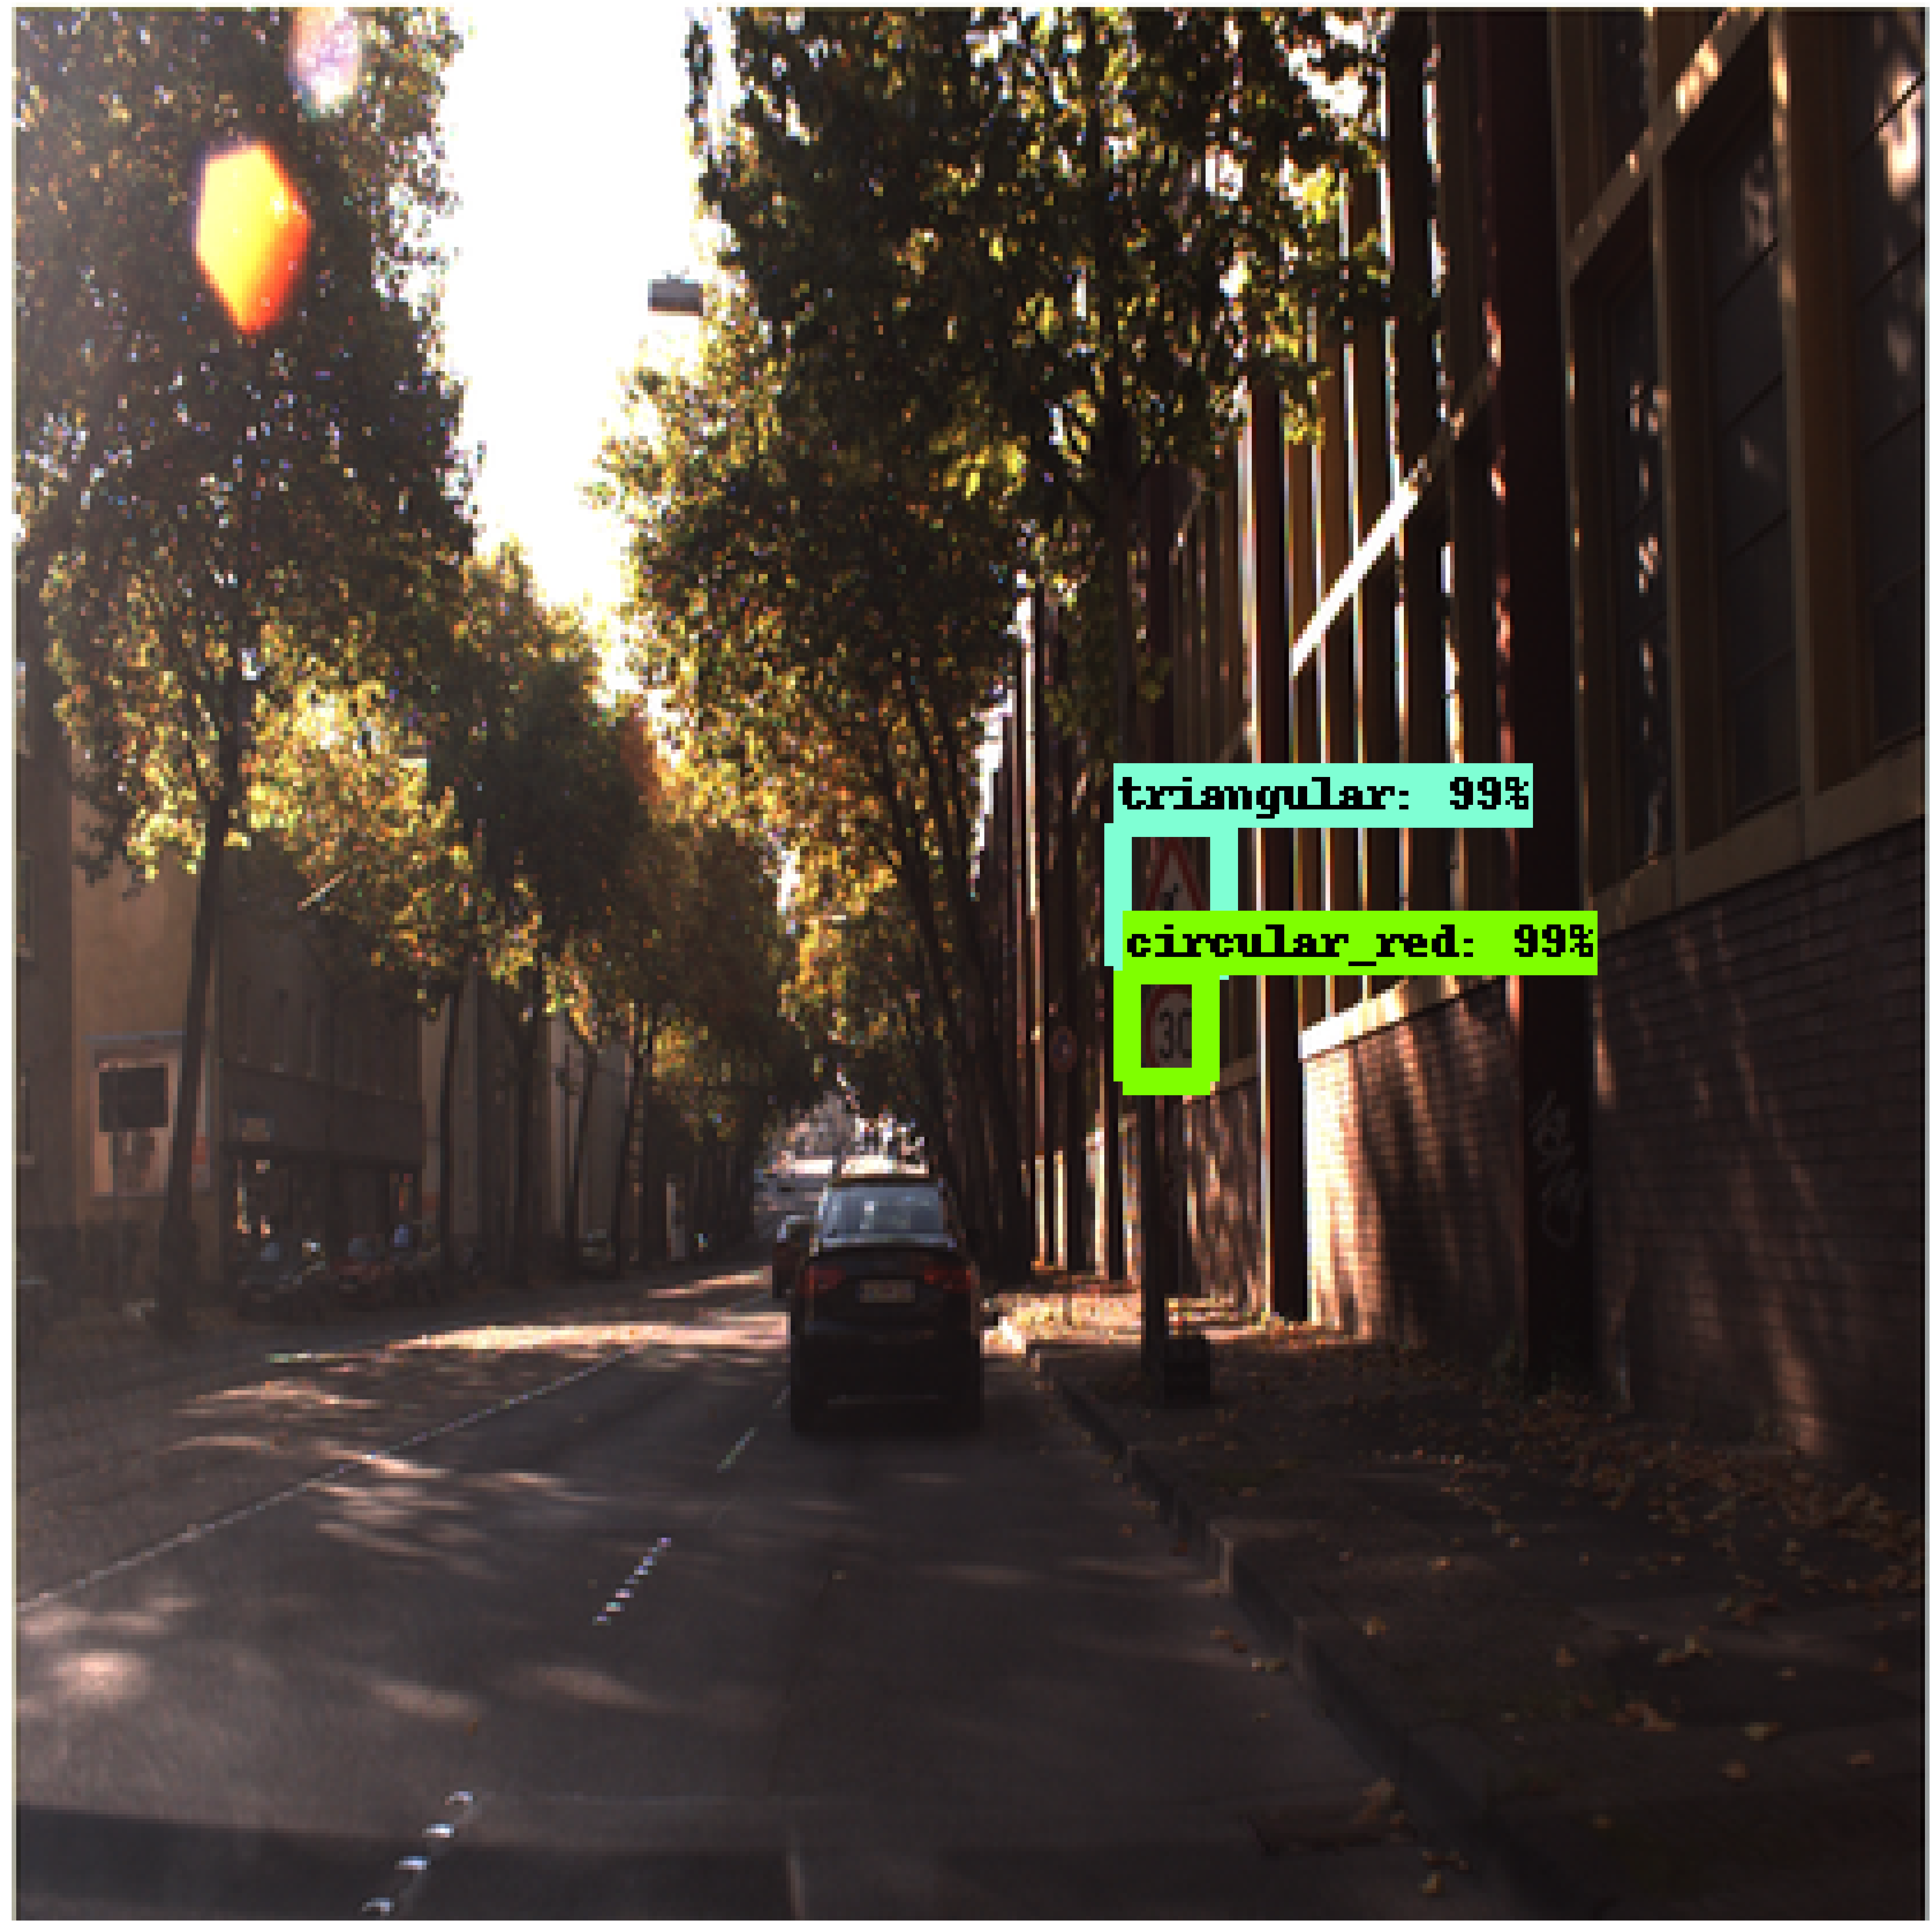

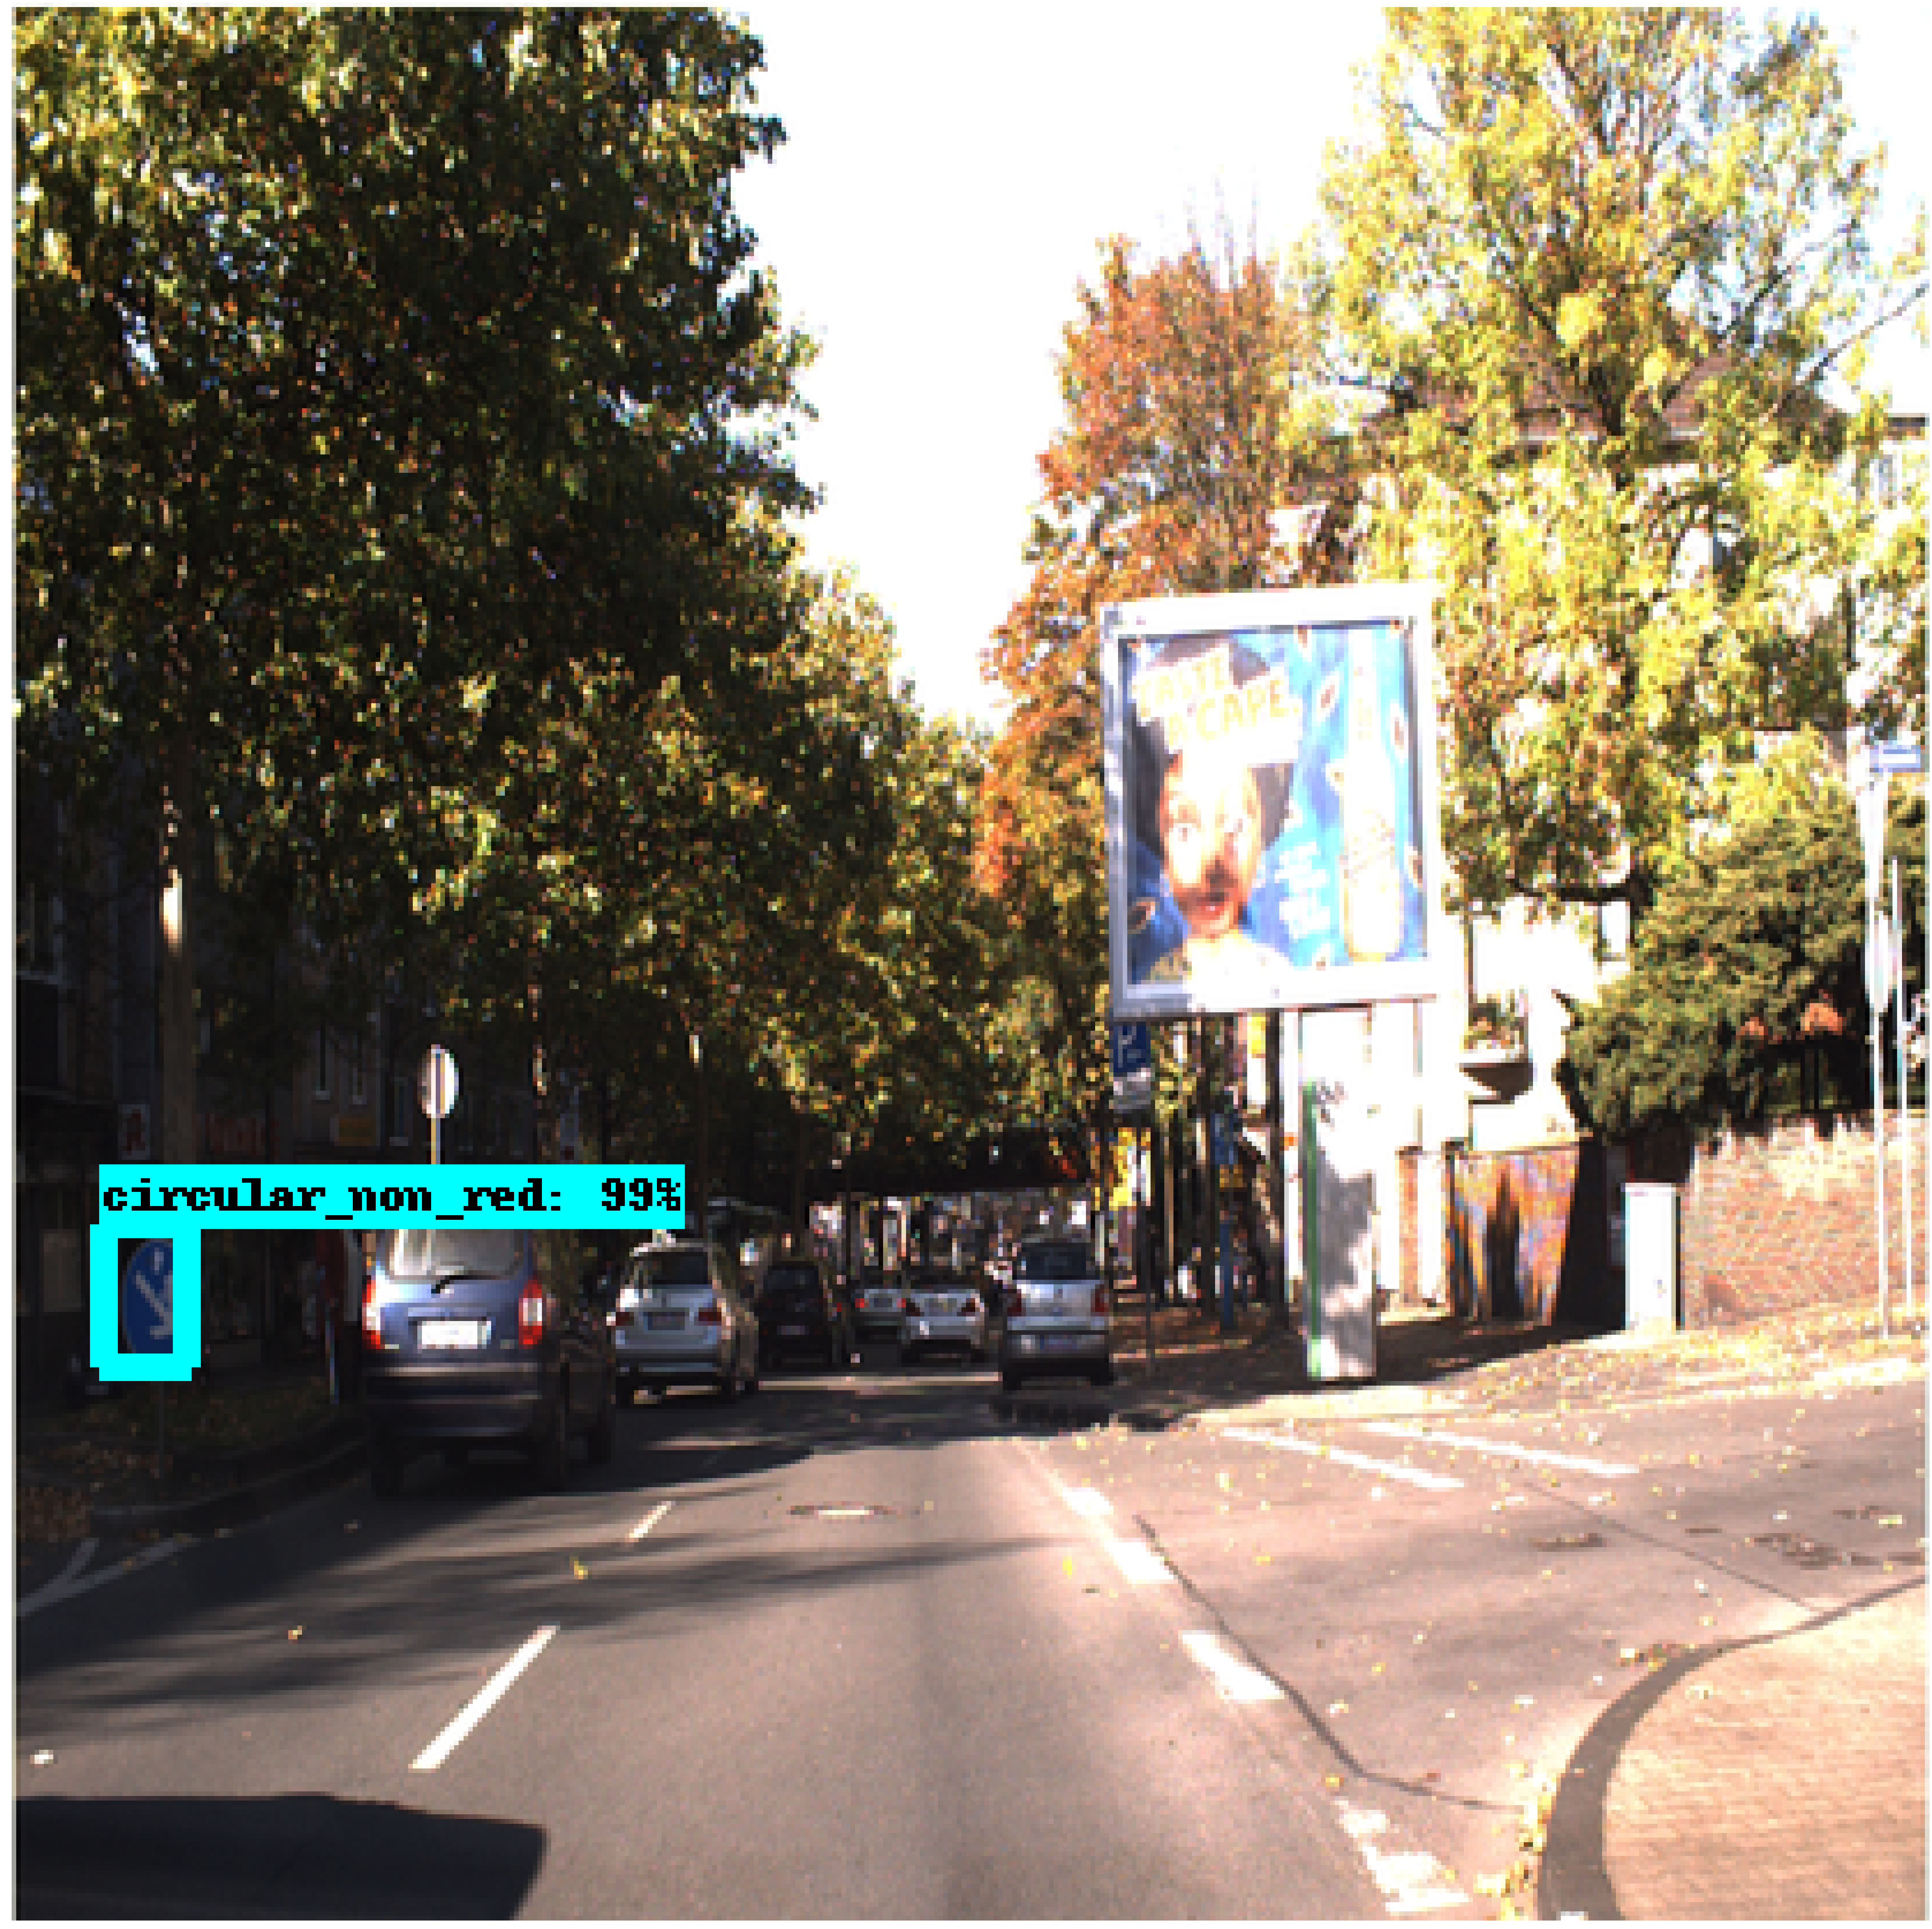

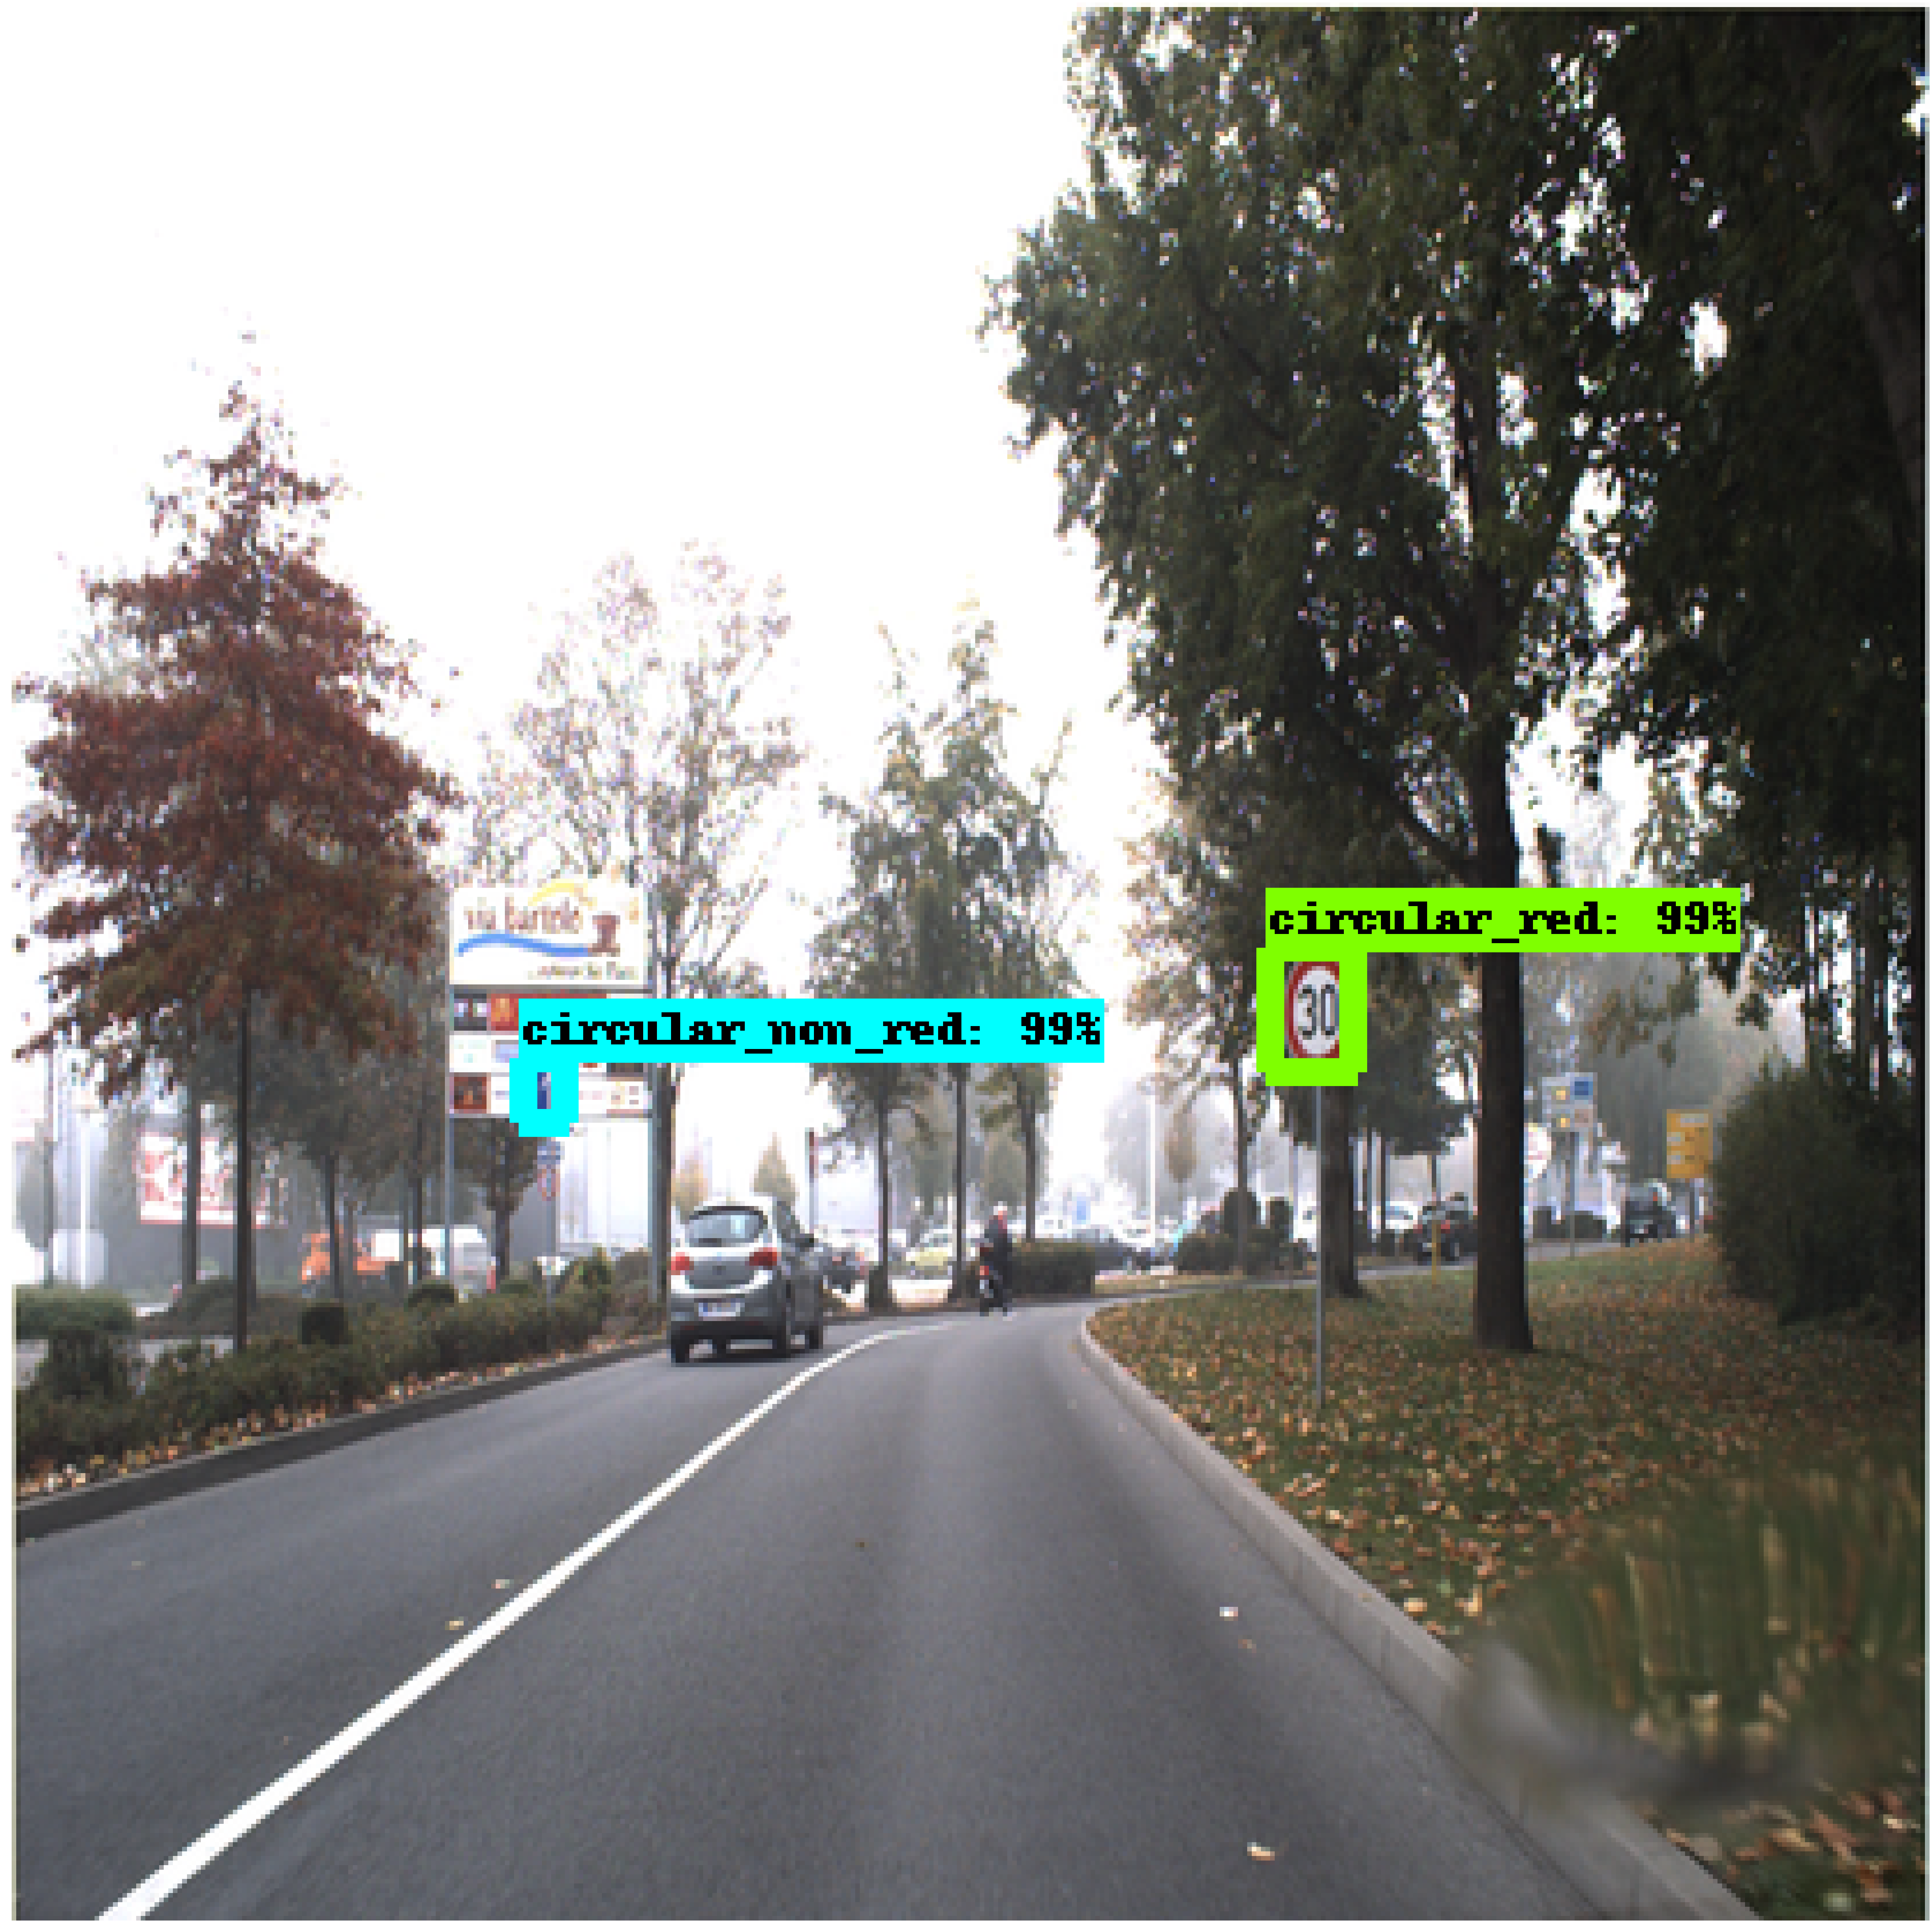

In [ ]:
out_glob = glob.glob((os.path.join(PATH_TO_OUTPUT_DIR, '*.png')))
idxs = set([1,4,9,12,25,34,44,51,80])
for idx, image_path in enumerate(out_glob):
    img_num = int(image_path.split('/')[-1].split('.')[0])
    if img_num in idxs:
        image = Image.open(image_path)
        plt.figure(idx, figsize=(100,100))
        plt.axis('off')
        plt.imshow(image)